In [1]:
import matplotlib.pyplot as plt
import numpy as np
import GPy
import pandas as pd

from gpr4im import fg_tools as fg
from gpr4im import pk_tools as pk

In [2]:
# for plotting:
%matplotlib inline

font = {"size": 16, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = True

In [3]:
# data:
data = pd.read_pickle('../../Data/data.pkl')
FGwpol_HI_noise_data = data.beam.FGwpol_HI_noise
HI_noise_data = data.beam.HI_noise
freqs = data.freqs
# multinest results:
multinest = pd.read_pickle('../../Data/multinest_results.pkl')

In [4]:
# Dimension of data cube:
lx, ly, lz = 1000,1000, 924.78 #Mpc/h
nx, ny, nz = 256, 256, 285

# minimum and maximum k in each direction:
kmin, kmin_perp, kmin_par = 2*np.pi/pow(lx*ly*lz, 1/3), 2*np.pi/np.sqrt(lx**2 + ly**2), 2*np.pi/lz
kmax, kmax_par, kmax_perp = 0.4, 0.4, 0.4

# set width of k bins to be 2*kmin
dk, dk_perp, dk_par = 2*kmin, 2*kmin_perp, 2*kmin_par

# number of k bins:
nkbin = int((kmax-kmin)/dk)
nkbin_perp = int((kmax_perp-kmin_perp)/dk_perp)
nkbin_par = int((kmax_par-kmin_par)/dk_par)

# setting array of k bin edges:
kbins = np.arange(kmin,kmax,dk)
kbins_perp = np.arange(kmin_perp,kmax_perp,dk_perp)
kbins_par = np.arange(kmin_par,kmax_par,dk_par)

# array of kbin centers:
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)
kperp = np.linspace(kmin_perp+0.5*dk_perp,kmax_perp-0.5*dk_perp,nkbin_perp)
kpar = np.linspace(kmin_par+0.5*dk_par,kmax_par-0.5*dk_par,nkbin_par)

### RFI gap case 1: 
removing 40% of the data in the middle of the frequency range

In [5]:
slice1 = slice(0, 86)
slice2 = slice(200, 285)

# frequency range:
freqs_sliced = np.concatenate([freqs[slice1], freqs[slice2]])

# window function:
ones1 = np.ones((256, 256, 86))
zeros1 = np.zeros((256, 256, 114))
ones2 = np.ones((256, 256, 85))
w = W = np.concatenate([ones1, zeros1, ones2], axis=2)

# data:
HI_noise_data_sliced = np.concatenate([HI_noise_data[:, :, slice1], zeros1, 
                                       HI_noise_data[:, :, slice2]], axis=2)
FGwpol_HI_noise_data_sliced = np.concatenate([FGwpol_HI_noise_data[:, :, slice1],
                                              FGwpol_HI_noise_data[:, :, slice2]], axis=2)

HI_pk1, nmodes1 = pk.getpk(HI_noise_data_sliced, w, W, nx,ny,nz,lx,ly,lz,kbins)
HI_pk_para1, nmodespar1 = pk.ParaPk(HI_noise_data_sliced, nx, ny, nz, lx, ly, lz, kbins_par, w, W)
HI_pk_perp1, nmodesperp1 = pk.PerpPk(HI_noise_data_sliced, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)

# PCA clean:
pca_res_6 = fg.PCAclean(FGwpol_HI_noise_data_sliced, N_FG=6)[0]
pca_res_6 = np.concatenate([pca_res_6[:, :, 0:86], zeros1,
                                          pca_res_6[:, :, 86:]], axis=2)
pca_res_7 = fg.PCAclean(FGwpol_HI_noise_data_sliced, N_FG=7)[0]
pca_res_7 = np.concatenate([pca_res_7[:, :, 0:86], zeros1,
                                          pca_res_7[:, :, 86:]], axis=2)
PCA6_pk1 = pk.getpk(pca_res_6, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
PCA6_pk_para1 = pk.ParaPk(pca_res_6, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]
PCA6_pk_perp1 = pk.PerpPk(pca_res_6, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]
PCA7_pk1 = pk.getpk(pca_res_7, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
PCA7_pk_para1 = pk.ParaPk(pca_res_7, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]
PCA7_pk_perp1 = pk.PerpPk(pca_res_7, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]

# GPR clean:
kern_smooth = GPy.kern.RBF(1, variance = multinest.wpol_rfi1.rbf1_var, lengthscale = multinest.wpol_rfi1.rbf1_len)
kern_pol = GPy.kern.RBF(1, variance = multinest.wpol_rfi1.rbf2_var, lengthscale = multinest.wpol_rfi1.rbf2_len)
kern_fg = kern_smooth + kern_pol
kern_21 = GPy.kern.Exponential(1, variance = multinest.wpol_rfi1.exp_var, lengthscale =  multinest.wpol_rfi1.exp_len)
gpr_result = fg.GPRclean(FGwpol_HI_noise_data_sliced, freqs_sliced, kern_fg, kern_21, num_restarts=0, NprePCA=0, 
                                        noise_data=None, heteroscedastic=False, zero_noise=True, invert=False)
gpr_reshape = np.concatenate([gpr_result.res[:, :, 0:86], zeros1,
                                          gpr_result.res[:, :, 86:]], axis=2)
GPR_pk1 = pk.getpk(gpr_reshape, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
GPR_pk_para1 = pk.ParaPk(gpr_reshape, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]
GPR_pk_perp1 = pk.PerpPk(gpr_reshape, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]

 /opt/anaconda3/envs/testgpr2/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /opt/anaconda3/envs/testgpr2/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


### RFI gap case 2: 
removing 40% of the data in the beginning of the frequency range

In [6]:
slice3 = slice(0, 29)
slice4 = slice(143, 285)
freqs_sliced = np.concatenate([freqs[slice3], freqs[slice4]])

# window function:
ones1 = np.ones((256, 256, 29))
zeros1 = np.zeros((256, 256, 114))
ones2 = np.ones((256, 256, 142))
w = W = np.concatenate([ones1, zeros1, ones2], axis=2)

# data:
HI_noise_data_sliced = np.concatenate([HI_noise_data[:, :, slice3], zeros1, 
                                       HI_noise_data[:, :, slice4]], axis=2)
FGwpol_HI_noise_data_sliced = np.concatenate([FGwpol_HI_noise_data[:, :, slice3],
                                              FGwpol_HI_noise_data[:, :, slice4]], axis=2)

HI_pk2, nmodes2 = pk.getpk(HI_noise_data_sliced,w,W,nx,ny,nz,lx,ly,lz,kbins)
HI_pk_para2, nmodespar2 = pk.ParaPk(HI_noise_data_sliced, nx, ny, nz, lx, ly, lz, kbins_par, w, W)
HI_pk_perp2, nmodesperp2 = pk.PerpPk(HI_noise_data_sliced, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)

# PCA clean:
pca_res_6 = fg.PCAclean(FGwpol_HI_noise_data_sliced, N_FG=6)[0]
pca_res_6 = np.concatenate([pca_res_6[:, :, 0:29], zeros1,
                                          pca_res_6[:, :, 29:]], axis=2)
pca_res_7 = fg.PCAclean(FGwpol_HI_noise_data_sliced, N_FG=7)[0]
pca_res_7 = np.concatenate([pca_res_7[:, :, 0:29], zeros1,
                                          pca_res_7[:, :, 29:]], axis=2)
PCA6_pk2 = pk.getpk(pca_res_6, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
PCA6_pk_para2 = pk.ParaPk(pca_res_6, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]
PCA6_pk_perp2 = pk.PerpPk(pca_res_6, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]
PCA7_pk2 = pk.getpk(pca_res_7, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
PCA7_pk_para2 = pk.ParaPk(pca_res_7, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]
PCA7_pk_perp2 = pk.PerpPk(pca_res_7, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]

# GPR clean:
kern_smooth = GPy.kern.RBF(1, variance = multinest.wpol_rfi2.rbf1_var, lengthscale = multinest.wpol_rfi2.rbf1_len)
kern_pol = GPy.kern.RBF(1, variance = multinest.wpol_rfi2.rbf2_var, lengthscale = multinest.wpol_rfi2.rbf2_len)
kern_fg = kern_smooth + kern_pol
kern_21 = GPy.kern.Exponential(1, variance = multinest.wpol_rfi2.exp_var, lengthscale =  multinest.wpol_rfi2.exp_len)
gpr_result = fg.GPRclean(FGwpol_HI_noise_data_sliced, freqs_sliced, kern_fg, kern_21, num_restarts=0, NprePCA=0, 
                                        noise_data=None, heteroscedastic=False, zero_noise=True, invert=False)
gpr_reshape = np.concatenate([gpr_result.res[:, :, 0:29], zeros1,
                                          gpr_result.res[:, :, 29:]], axis=2)
GPR_pk2 = pk.getpk(gpr_reshape, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
GPR_pk_para2 = pk.ParaPk(gpr_reshape, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]
GPR_pk_perp2 = pk.PerpPk(gpr_reshape, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]

### RFI gap case 3:

20% good, 30% flagged, 20% good, 10% flagged, 20% good.

In [7]:
slice5 = slice(0, 57)
slice6 = slice(143, 200)
slice7 = slice(228, 285)
freqs_sliced = np.concatenate([freqs[slice5], freqs[slice6], freqs[slice7]])

# window function:
ones1 = np.ones((256, 256, 57))
zeros1 = np.zeros((256, 256, 86))
ones2 = np.ones((256, 256, 57))
zeros2 = np.zeros((256, 256, 28))
ones3 = np.ones((256, 256, 57))
w = W = np.concatenate([ones1, zeros1, ones2, zeros2, ones3], axis=2)

HI_noise_data_sliced = np.concatenate([HI_noise_data[:, :, slice5], zeros1, HI_noise_data[:, :, slice6],
                                       zeros2, HI_noise_data[:, :, slice7]], axis=2)
FGwpol_HI_noise_data_sliced = np.concatenate([FGwpol_HI_noise_data[:, :, slice5], FGwpol_HI_noise_data[:, :, slice6],
                                              FGwpol_HI_noise_data[:, :, slice7]], axis=2)

HI_pk3, nmodes3 = pk.getpk(HI_noise_data_sliced,w,W,nx,ny,nz,lx,ly,lz,kbins)
HI_pk_para3, nmodespar3 = pk.ParaPk(HI_noise_data_sliced, nx, ny, nz, lx, ly, lz, kbins_par, w, W)
HI_pk_perp3, nmodesperp3 = pk.PerpPk(HI_noise_data_sliced, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)

# PCA clean:
pca_res_6 = fg.PCAclean(FGwpol_HI_noise_data_sliced, N_FG=6)[0]
pca_res_7 = fg.PCAclean(FGwpol_HI_noise_data_sliced, N_FG=7)[0]
pca_res_6 = np.concatenate([pca_res_6[:, :, 0:57], zeros1, pca_res_6[:, :, 57:114], zeros2,
                                          pca_res_6[:, :, 114:171]], axis=2)
pca_res_7 = np.concatenate([pca_res_7[:, :, 0:57], zeros1, pca_res_7[:, :, 57:114], zeros2,
                                          pca_res_7[:, :, 114:171]], axis=2)
PCA6_pk3 = pk.getpk(pca_res_6, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
PCA6_pk_para3 = pk.ParaPk(pca_res_6, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]
PCA6_pk_perp3 = pk.PerpPk(pca_res_6, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]
PCA7_pk3 = pk.getpk(pca_res_7, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
PCA7_pk_para3 = pk.ParaPk(pca_res_7, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]
PCA7_pk_perp3 = pk.PerpPk(pca_res_7, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]

# GPR clean:
kern_smooth = GPy.kern.RBF(1, variance = multinest.wpol_rfi3.rbf1_var, lengthscale = multinest.wpol_rfi3.rbf1_len)
kern_pol = GPy.kern.RBF(1, variance = multinest.wpol_rfi3.rbf2_var, lengthscale = multinest.wpol_rfi3.rbf2_len)
kern_fg = kern_smooth + kern_pol
kern_21 = GPy.kern.Exponential(1, variance = multinest.wpol_rfi3.exp_var, lengthscale =  multinest.wpol_rfi3.exp_len)
gpr_result = fg.GPRclean(FGwpol_HI_noise_data_sliced, freqs_sliced, kern_fg, kern_21, num_restarts=0, NprePCA=0, 
                                        noise_data=None, heteroscedastic=False, zero_noise=True, invert=False)
gpr_reshape = np.concatenate([gpr_result.res[:, :, 0:57], zeros1, gpr_result.res[:, :, 57:114], zeros2,
                                          gpr_result.res[:, :, 114:171]], axis=2)
GPR_pk3 = pk.getpk(gpr_reshape,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]
GPR_pk_para3 = pk.ParaPk(gpr_reshape, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]
GPR_pk_perp3 = pk.PerpPk(gpr_reshape, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]

Ignore first point due to low number of modes:

In [9]:
k = k[1:]
HI_pk1, HI_pk2, HI_pk3 = HI_pk1[1:], HI_pk2[1:], HI_pk3[1:]
PCA7_pk1, PCA7_pk2, PCA7_pk3 = PCA7_pk1[1:], PCA7_pk2[1:], PCA7_pk3[1:]
PCA6_pk1, PCA6_pk2, PCA6_pk3 = PCA6_pk1[1:], PCA6_pk2[1:], PCA6_pk3[1:]
GPR_pk1, GPR_pk2, GPR_pk3 = GPR_pk1[1:], GPR_pk2[1:], GPR_pk3[1:]

In [10]:
kpar = kpar[1:]
HI_pk_para1, HI_pk_para2, HI_pk_para3 = HI_pk_para1[1:], HI_pk_para2[1:], HI_pk_para3[1:]
GPR_pk_para1, GPR_pk_para2, GPR_pk_para3 = GPR_pk_para1[1:], GPR_pk_para2[1:], GPR_pk_para3[1:]
PCA7_pk_para1, PCA7_pk_para2, PCA7_pk_para3 = PCA7_pk_para1[1:], PCA7_pk_para2[1:], PCA7_pk_para3[1:]
PCA6_pk_para1, PCA6_pk_para2, PCA6_pk_para3 = PCA6_pk_para1[1:], PCA6_pk_para2[1:], PCA6_pk_para3[1:]

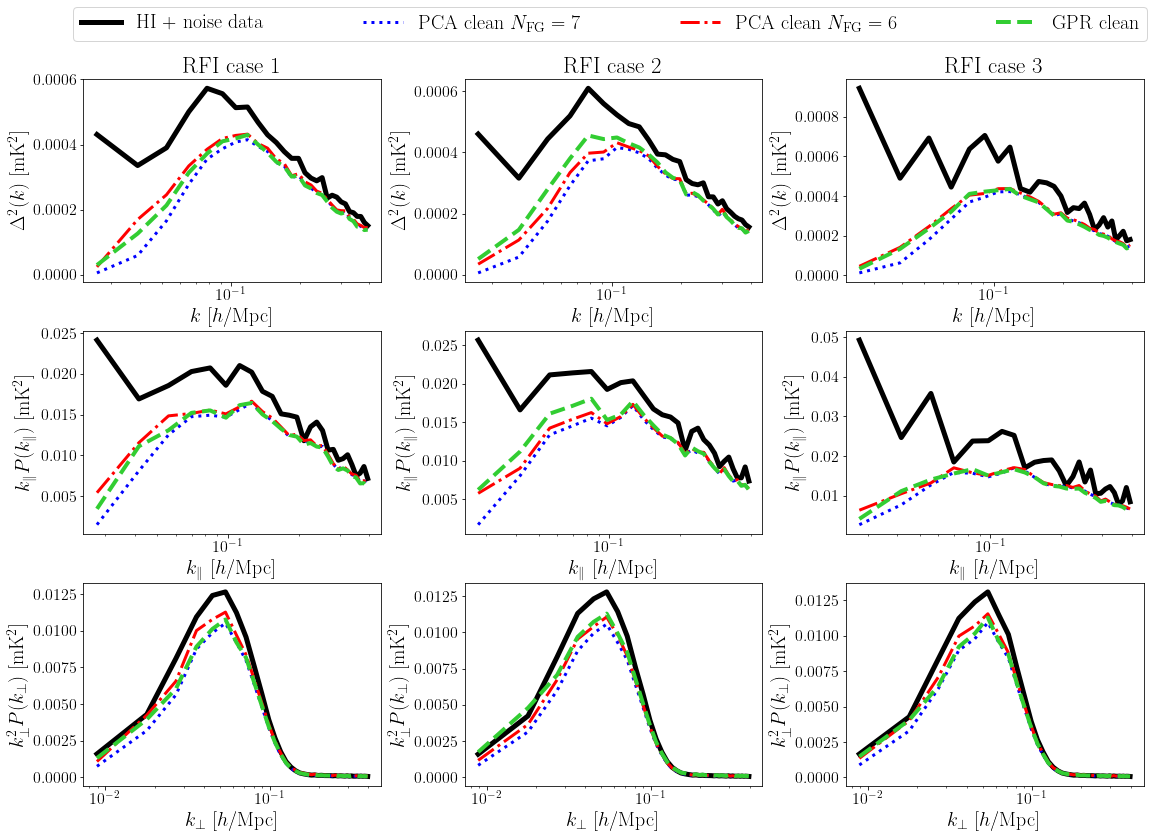

In [13]:
fig, ((ax1, ax3, ax5), (ax2, ax4, ax6), (ax7, ax8, ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(19,13))
fig.subplots_adjust(hspace=0.24, wspace=0.28)

ax1.plot(k, (k*k*k*HI_pk1)/(2*np.pi*np.pi), ls='solid', c='k', lw=5, label = r'HI + noise data')
ax1.plot(k, (k*k*k*PCA7_pk1)/(2*np.pi*np.pi), ls='dotted',c='b', lw=3)
ax1.plot(k, (k*k*k*PCA6_pk1)/(2*np.pi*np.pi), ls='dashdot',c='r', lw=3)
ax1.plot(k, (k*k*k*GPR_pk1)/(2*np.pi*np.pi), ls='dashed', c='limegreen', lw=4)
ax1.set_title('RFI case 1', fontsize = 23)
ax1.set_xscale('log')
ax1.set_xlabel('$k$ [$h$/Mpc]', fontsize=20)
ax1.set_ylabel('$\Delta^2 (k)$ [mK$^2$]', fontsize=20)

ax2.plot(kpar, kpar*HI_pk_para1, ls='solid',c='k', lw=5)
ax2.plot(kpar, kpar*PCA7_pk_para1, ls='dotted',c='b', lw=3)
ax2.plot(kpar, kpar*PCA6_pk_para1, ls='dashdot',c='r', lw=3)
ax2.plot(kpar, kpar*GPR_pk_para1, ls='dashed', c='limegreen', lw=4)
ax2.set_xscale('log')
ax2.set_xlabel('$k_\parallel$ [$h$/Mpc]', fontsize=20)
ax2.set_ylabel('$k_\parallel P(k_\parallel)$ [mK$^2$]', fontsize=20)

ax3.plot(k, (k*k*k*HI_pk2)/(2*np.pi*np.pi), ls='solid', c='k', lw=5)
ax3.plot(k, (k*k*k*PCA7_pk2)/(2*np.pi*np.pi), ls='dotted',c='b', lw=3, label = r'PCA clean $N_{\rm FG} = 7$')
ax3.plot(k, (k*k*k*PCA6_pk2)/(2*np.pi*np.pi), ls='dashdot',c='r', lw=3)
ax3.plot(k, (k*k*k*GPR_pk2)/(2*np.pi*np.pi), ls='dashed', c='limegreen', lw=4)
ax3.set_title('RFI case 2', fontsize = 23)
ax3.set_xlabel('$k$ [$h$/Mpc]', fontsize=20)
ax3.set_xscale('log')
ax3.set_ylabel('$\Delta^2 (k)$ [mK$^2$]', fontsize=20)

ax4.plot(kpar, kpar*HI_pk_para2, ls='solid',c='k', lw=5)
ax4.plot(kpar, kpar*PCA7_pk_para2, ls='dotted',c='b', lw=3)
ax4.plot(kpar, kpar*PCA6_pk_para2, ls='dashdot',c='r', lw=3)
ax4.plot(kpar, kpar*GPR_pk_para2, ls='dashed', c='limegreen', lw=4)
ax4.set_xscale('log')
ax4.set_xlabel('$k_\parallel$ [$h$/Mpc]', fontsize=20)
ax4.set_ylabel('$k_\parallel P(k_\parallel)$ [mK$^2$]', fontsize=20)

ax5.plot(k, (k*k*k*HI_pk3)/(2*np.pi*np.pi), ls='solid', c='k', lw=5)
ax5.plot(k, (k*k*k*PCA7_pk3)/(2*np.pi*np.pi), ls='dotted',c='b', lw=3)
ax5.plot(k, (k*k*k*PCA6_pk3)/(2*np.pi*np.pi), ls='dashdot',c='r', lw=3, label = r'PCA clean $N_{\rm FG} = 6$')
ax5.plot(k, (k*k*k*GPR_pk3)/(2*np.pi*np.pi), ls='dashed', c='limegreen', lw=4, label = r'GPR clean')
ax5.set_title('RFI case 3', fontsize = 23)
ax5.set_xlabel('$k$ [$h$/Mpc]', fontsize=20)
ax5.set_xscale('log')
ax5.set_ylabel('$\Delta^2 (k)$ [mK$^2$]', fontsize=20)

ax6.plot(kpar, kpar*HI_pk_para3, ls='solid',c='k', lw=5)
ax6.plot(kpar, kpar*PCA7_pk_para3, ls='dotted',c='b', lw=3)
ax6.plot(kpar, kpar*PCA6_pk_para3,ls='dashdot',c='r', lw=3)
ax6.plot(kpar, kpar*GPR_pk_para3, ls='dashed', c='limegreen', lw=4)
ax6.set_xscale('log')
ax6.set_xlabel('$k_\parallel$ [$h$/Mpc]', fontsize=20)
ax6.set_ylabel('$k_\parallel P(k_\parallel)$ [mK$^2$]', fontsize=20)

ax7.plot(kperp, kperp*kperp*HI_pk_perp1, ls='solid',c='k', lw=5)
ax7.plot(kperp, kperp*kperp*PCA7_pk_perp1, ls='dotted',c='b', lw=3)
ax7.plot(kperp, kperp*kperp*PCA6_pk_perp1, ls='dashdot',c='r', lw=3)
ax7.plot(kperp, kperp*kperp*GPR_pk_perp1, ls='dashed', c='limegreen', lw=4)
ax7.set_xscale('log')
ax7.set_xlabel('$k_\perp$ [$h$/Mpc]', fontsize=20)
ax7.set_ylabel('$k_\perp^2 P(k_\perp)$ [mK$^2$]', fontsize=20)

ax8.plot(kperp, kperp*kperp*HI_pk_perp2, ls='solid',c='k', lw=5)
ax8.plot(kperp, kperp*kperp*PCA7_pk_perp2, ls='dotted',c='b', lw=3)
ax8.plot(kperp, kperp*kperp*PCA6_pk_perp2, ls='dashdot',c='r', lw=3)
ax8.plot(kperp, kperp*kperp*GPR_pk_perp2, ls='dashed', c='limegreen', lw=4)
ax8.set_xscale('log')
ax8.set_xlabel('$k_\perp$ [$h$/Mpc]', fontsize=20)
ax8.set_ylabel('$k_\perp^2 P(k_\perp)$ [mK$^2$]', fontsize=20)

ax9.plot(kperp, kperp*kperp*HI_pk_perp3, ls='solid',c='k', lw=5)
ax9.plot(kperp, kperp*kperp*PCA7_pk_perp3, ls='dotted',c='b', lw=3)
ax9.plot(kperp, kperp*kperp*PCA6_pk_perp3, ls='dashdot',c='r', lw=3)
ax9.plot(kperp, kperp*kperp*GPR_pk_perp3, ls='dashed', c='limegreen', lw=4)
ax9.set_xscale('log')
ax9.set_xlabel('$k_\perp$ [$h$/Mpc]', fontsize=20)
ax9.set_ylabel('$k_\perp^2 P(k_\perp)$ [mK$^2$]', fontsize=20)

fig.legend(bbox_to_anchor=(0.11, 0.91, 0.8, 0), loc="lower left", mode="expand", ncol=4, fontsize=20)

#plt.savefig('figs/pks_rfi', dpi=300, bbox_inches="tight")